### <span style="color:rgb(92,29,79)">Optimization for Machine Learning - Stochastic gradient methods</span>
### <span style="color:rgb(92,29,79)">Master 2 IASD & Master 2 MASH, 2023-2024</span>

# <span style="color:rgb(92,29,79)">Lab 01 - Stochastic gradient VS Gradient descent</span>


Lecture notes for this course are available [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/SG/LectureNotesOML-SG.pdf).

This Jupyter notebook can be obtained [here](https://www.lamsade.dauphine.fr/~croyer/ensdocs/SG/SourcesLabSG01.zip).

For any comment regarding this notebook (including typos), please send an email to: **clement.royer@lamsade.dauphine.fr**.

# <span style="color:rgb(92,29,79)">Introduction</span>

The goal of this lab session is to compare the behavior of gradient descent and stochastic gradient techniques on two different regression problems that possess a finite-sum structure. In particular, we aim at connecting the results discussed in class with actual practical behavior (illustrated on synthetic data).




In [1]:
# Preamble: useful toolboxes, librairies, functions, etc.

%matplotlib inline
import matplotlib.pyplot as plt

from math import sqrt # Square root

# NumPy - Matrix and vector structures
import numpy as np # NumPy library
from numpy.random import multivariate_normal, randn # Probability distributions on vectors

# SciPy - Efficient mathematical calculation
from scipy.linalg.special_matrices import toeplitz # A special kind of matrices
from scipy.linalg import svdvals # Singular values
from scipy.linalg import norm # Euclidean norm
from scipy.optimize import check_grad # Check accuracy between objective and gradient values
from scipy.optimize import fmin_l_bfgs_b # Efficient optimizer

C:\Users\jules\AppData\Local\Temp\ipykernel_6960\3430321006.py:13: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz # A special kind of matrices


# <span style="color:rgb(92,29,79)">Part 1 - Data generation and finite-sum problems</span>



In this section, we introduce two finite-sum problems based on learning a linear model from synthetic data.

## <span style="color:rgb(92,29,79)">1.1 - Generating the data</span>

We consider a dataset $\{(\mathbf{a}_i,y_i)\}_{i=1,\dots,n}$, where $\mathbf{a}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$, available in the form of:

- a feature matrix $\mathbf{A} \in \mathbb{R}^{n \times d}$;
- and a vector of labels $\mathbf{y} \in \mathbb{R}^n$. 

Given this dataset, we seek a model parameterized by a vector $w$ that explains the data according to a certain loss function. This results in the following formulation:
$$
    \min_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) = \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad f_i(\mathbf{x}) = \ell(h(\mathbf{a}_i,\mathbf{x}),y_i) + \frac{\lambda}{2}\|\mathbf{x}\|^2.
$$
where $\lambda \ge 0$ is an optional regularization parameter *(more on this in the lectures on regularization)*.

The dataset will be produced according to the procedure below.

In [2]:
# Data generation.
# This code is inspired by a generator proposed by A. Gramfort.

def simu_linmodel(x, n, std=1., corr=0.5):
    """
    Simulation values obtained by a linear model with additive noise
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the feature matrix
    """    
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = A.dot(x) + noise
    return A, y

The data is thus produced from a linear model corrupted with noise: $\mathbf{y} = \mathbf{A} \mathbf{x}^* + \mathbf{\epsilon}$, where $\mathbf{\epsilon}$ follows a Gaussian distribution. Our goal will thus be to learn a linear model from the data.

Note that the feature vectors are correlated so as to increase interest of stochastic gradient approaches. 

## <span style="color:rgb(92,29,79)">1.2 Linear regression</span>

In *linear regression*, we seek a linear model that explains the data based on minimizing a least-squares objective:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{2 n} \|\mathbf{A} \mathbf{x} - \mathbf{y}\|^2 + \frac{\lambda}{2}\|\mathbf{x}\|^2 
    = \frac{1}{n} \left(\frac{1}{2}\sum_{i=1}^n (\mathbf{a}_i^T \mathbf{x} - y_i)^2 + \frac{\lambda}{2}\|\mathbf{x}\|^2 \right).
$$ 
This problem has the form of a finite sum $f(\mathbf{x})=\tfrac{1}{n}\sum_{i=1}^n f_i(\mathbf{x})$, where 
$$
    f_i(\mathbf{x}) = \frac{1}{2} (\mathbf{a}_i^T \mathbf{x} - y_i)^2 + \frac{\lambda}{2} \|\mathbf{x}\|^2.
$$

**Observations:**

1. For any $i$, the function $f_i$ is quadratic in $\mathbf{x}$, since
$$
    f_i(\mathbf{x}) = \frac{1}{2} \mathbf{x}^T \mathbf{a}_i \mathbf{a}_i^T \mathbf{x} + \frac{\lambda}{2}\mathbf{x}^T \mathbf{x}- y_i \mathbf{a}_i^T \mathbf{x} + \frac{1}{2} y_i^2,
$$
hence
$$
    \nabla f_i(\mathbf{x}) = (\mathbf{a}_i^T \mathbf{x} - y_i)\mathbf{a}_i + \lambda \mathbf{x}.
$$
2. One can use the result from 1. and identify the expressions. Another approach consists in rewriting the objective function as
$$
    f(\mathbf{x}) = \frac{1}{2}\mathbf{x}^T \left(\frac{\mathbf{A}^T \mathbf{A}}{n} + \lambda \mathbf{I}_d\right)\mathbf{x} - \frac{1}{n}\mathbf{y}^T \mathbf{A} \mathbf{x} + \frac{1}{2} \mathbf{y}^T \mathbf{y}.
$$
The gradient of the objective function above is given by:
$$
    \nabla f(\mathbf{x}) = \left( \frac{\mathbf{A}^T \mathbf{A}}{n} + \lambda \mathbf{I}_d \right)\mathbf{x} - \frac{1}{n}\mathbf{A}^T \mathbf{y}
    = \frac{1}{n}\mathbf{A}^T (\mathbf{A} \mathbf{x} - \mathbf{y}) + \lambda \mathbf{x}.
$$
3. For any $\mathbf{x},\mathbf{w} \in \mathbb{R}^d$, the formula for the gradient gives:
$$
    \|\nabla f(\mathbf{w}) -\nabla f(\mathbf{x})\| 
    = \left\|\frac{\mathbf{A}^T \mathbf{A}}{n} \mathbf{x} + \lambda \mathbf{x} - \frac{\mathbf{A}^T \mathbf{A}}{n}\mathbf{w} - \lambda \mathbf{w} \right\| 
    \le \frac{\|\mathbf{A}^T \mathbf{A}\|}{n}\|\mathbf{x}-\mathbf{w}\| + \lambda \|\mathbf{x}-\mathbf{w}\|.
$$
The gradient $\nabla f$ is thus $\left(\frac{\|\mathbf{A}^T \mathbf{A}\|}{n}+\lambda\right)$-Lipschitz continuous.

## <span style="color:rgb(92,29,79)">1.3 Logistic regression</span>

In *logistic regression*, we still consider a linear model, but we use a loss function better suited for classification:
$$
    \mathrm{minimize}_{\mathbf{x} \in \mathbb{R}^d} f(\mathbf{x}) 
    := \frac{1}{n} \sum_{i=1}^n f_i(\mathbf{x}), \qquad 
    f_i(\mathbf{x})=\log(1+\exp(-y_i \mathbf{a}_i^T \mathbf{x}))+\frac{\lambda}{2}\|\mathbf{x}\|^2,
$$
where every $y_i$ is a binary label in $\{-1,1\}$ and $\lambda \ge 0$ is a regularization parameter.

**Observations:**

1. The derivative of $t \mapsto \log(1+\exp(-t))$ is $t \mapsto \frac{-\exp(-t)}{1+\exp(-t)} = -\frac{1}{1+\exp(t)}$. Combining this with the linear function $\mathbf{x} \mapsto y_i \mathbf{a}_i^T \mathbf{x}$, we get for every $i$ that
$$
\nabla f_i(\mathbf{x}) = - \frac{y_i}{1 + \exp(y_i \mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i + \lambda \mathbf{x}.
$$
and 
$$
\nabla f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n  -\frac{y_i}{1 + \exp(y_i \mathbf{a}_i^T \mathbf{x})} \mathbf{a}_i + \lambda \mathbf{x}
$$
2. One way to obtain a Lipschitz constant for the gradient is to bound the second-order derivative, which is given by:
$$
\nabla^2 f(\mathbf{x}) = \frac{1}{n}\sum_{i=1}^n  
\frac{\exp(-y_i \mathbf{a}_i^T \mathbf{x})}{(1 + \exp(-y_i \mathbf{a}_i^T \mathbf{x}))^2} \mathbf{a}_i \mathbf{a}_i^T + \lambda I,
$$
where $I$ is the identity matrix. The result follows by noticing that $t \mapsto \tfrac{e^{t}}{(1+\exp(t))^2}$  is always less than or equal to $\tfrac{1}{4}$ (its value at the origin), we obtain that
$$
\| \nabla^2 f(\mathbf{x}) \| \le L:=\frac{\|\mathbf{A}^T \mathbf{A}\|}{4n}+\lambda,
$$
hence $\nabla f$ is $L$-Lipschitz continuous.

## <span style="color:rgb(92,29,79)">1.4 Python class for regression problems</span>

*Implementation: Using the formulae developed above, add the code to compute $f(\mathbf{x})$, $f_i(\mathbf{x})$, $\nabla f_i(\mathbf{x})$ and $\nabla f(\mathbf{x})$ within the Python class encoding the two regression problems above.*

*Useful functions:* For any matrix/2-way Numpy array A,

- A.dot(v) is the matrix-vector product $A v$ (if A is a vector, this returns the scalar product);
- A.T is the transpose matrix $A^T$.

- np.log : logarithm applied componentwise on Numpy arrays.
- np.mean : average of the components of a NumPy array

In [3]:
# Python class for regression problems
class RegPb(object):
    '''
        A class for regression problems with linear models.
        
        Attributes:
            A: Data matrix (features)
            y: Data vector (labels)
            n,d: Dimensions of A
            loss: Loss function to be considered in the regression
                'l2': Least-squares loss
                'logit': Logistic loss
            lbda: Regularization parameter
    '''
   
    # Instantiate the class
    def __init__(self, A, y,lbda=0,loss='l2'):
        self.A = A
        self.y = y
        self.n, self.d = A.shape
        self.loss = loss
        self.lbda = lbda
        
    
    # Objective value
    def fun(self, x):
        if self.loss=='l2':
            return norm(self.A.dot(x) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            return np.mean(np.log(1. + np.exp(-yAx))) + self.lbda * norm(x) ** 2 / 2.
    
    # Partial objective value
    def f_i(self, i, x):
        if self.loss=='l2':
            return norm(self.A[i].dot(x) - self.y[i]) ** 2 / (2.) + self.lbda * norm(x) ** 2 / 2.
        elif self.loss=='logit':
            yAxi = self.y[i] * np.dot(self.A[i], x)
            return np.log(1. + np.exp(- yAxi)) + self.lbda * norm(x) ** 2 / 2.
    
    # Full gradient computation
    def grad(self, x):
        if self.loss=='l2':
            return self.A.T.dot(self.A.dot(x) - self.y) / self.n + self.lbda * x
        elif self.loss=='logit':
            yAx = self.y * self.A.dot(x)
            aux = 1. / (1. + np.exp(yAx))
            return - (self.A.T).dot(self.y * aux) / self.n + self.lbda * x
    
    # Partial gradient
    def grad_i(self,i,x):
        a_i = self.A[i]
        if self.loss=='l2':
            return (a_i.dot(x) - self.y[i]) * a_i + self.lbda*x
        elif self.loss=='logit':
            grad = - a_i * self.y[i] / (1. + np.exp(self.y[i] * a_i.dot(x)))
            grad += self.lbda * x
            return grad

    # Lipschitz constant for the gradient
    def lipgrad(self):
        if self.loss=='l2':
            L = norm(self.A, ord=2) ** 2 / self.n + self.lbda
        elif self.loss=='logit':
            L = norm(self.A, ord=2) ** 2 / (4. * self.n) + self.lbda
        return L
    
    # ''Strong'' convexity constant (could be zero if self.lbda=0)
    def cvxval(self):
        if self.loss=='l2':
            s = svdvals(self.A)
            mu = min(s)**2 / self.n # More efficient than computing ||A^T A||
            return mu + self.lbda
        elif self.loss=='logit':
            return self.lbda

The first script below generates two problem instances (one for each class), the second checks the implementation of the derivatives, and the third one computes an approximate solution for each problem.

In [4]:
# Generate the problem instances - we use moderate sizes but those will serve our purpose

d = 50
n = 1000
idx = np.arange(d)
lbda = 1. / n ** (0.5)

# Fix random seed for reproducibility
np.random.seed(1)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

Alin, ylin = simu_linmodel(x_model_truth, n, std=1., corr=0.1)
Alog, ylog = simu_linmodel(x_model_truth, n, std=1., corr=0.7)
ylog = np.sign(ylog) # Taking the logarithm for binary classification

pblinreg = RegPb(Alin, ylin,lbda,loss='l2')
pblogreg = RegPb(Alog, ylog,lbda,loss='logit')

In [5]:
# Check correctness of the gradient functions compared to a finite-difference estimate
# Note: this is a check of the implementation of the gradient and the function value. If correct, the 
# output value, which represents the difference between a gradient and its estimation from function values, 
# should be of order 1e-06 at most.
# (See the lecture by Mathieu Blondel on automatic differentiation)

# Check for the linear regression problem
print(check_grad(pblinreg.fun, pblinreg.grad, np.random.randn(d)))
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((pblinreg.f_i( ind[0], w+eps*vec) - pblinreg.f_i( ind[0], w))/eps - np.dot(pblinreg.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

# Check for the logistic regression problem
print(check_grad(pblogreg.fun, pblogreg.grad, np.random.randn(d)))
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    grad_error.append((pblogreg.f_i( ind[0], w+eps*vec) - pblogreg.f_i( ind[0], w))/eps - np.dot(pblogreg.grad_i(ind[0],w),vec)) 
print(np.mean(grad_error))

1.9316800322978135e-06
2.6537551281015925e-06
1.569117993150448e-07
2.1605846826692337e-07


In this lab, we work with relatively simple loss functions (and a moderate number of data points): we can thus efficiently compute a solution using a second-order method. This provides us with a target objective value as well as a target vector of weights.

In [6]:
# Use L-BFGS-B to determine a solution for both problems

x_init = np.zeros(d)
# Compute the optimal solution for linear regression
x_min_lin, f_min_lin, _ = fmin_l_bfgs_b(pblinreg.fun, x_init, pblinreg.grad, args=(), pgtol=1e-30, factr =1e-30)
print(f_min_lin)
print(norm(pblinreg.grad(x_min_lin)))
# Compute the optimal solution for logistic regression
x_min_log, f_min_log, _ = fmin_l_bfgs_b(pblogreg.fun, x_init, pblogreg.grad, args=(), pgtol=1e-30, factr =1e-30)

print(f_min_log)
print(norm(pblogreg.grad(x_min_log)))

0.5562291656828048
1.1451287343750319e-10
0.5588577967545119
3.754624398098095e-09


These solutions will enable us to study the behavior of the distance to optimality in terms of function values 
$f(\mathbf{x}_k)-f^*$ and iterates $\|\mathbf{x}_k -\mathbf{x}^*\|$. 

*Note: Recall that $\|\nabla f(\mathbf{x}_k)\| \ge 2 \mu (f(\mathbf{x}_k)-f^*)$ for a $\mu$-strongly convex, continuously differentiable function with optimal value $f^*$, thus the gradient could also be used as an upper estimate of the distance to optimality in terms of function values. In terms of access to data points, however, both quantities are expensive.*

# <span style="color:rgb(92,29,79)">Part 2 - Gradient and stochastic gradient methods</span>

Having defined our problems, we now build a generic stochastic gradient method for comparison with gradient descent. We will then try to tune the batch size. 

## <span style="color:rgb(92,29,79)"> 2.1 Generic stochastic gradient framework</span>

The iteration of stochastic gradient (also called *Stochastic Gradient Descent*, or *SGD*) is given by:

$$
    \mathbf{x}_{k+1} = \mathbf{x}_k - \alpha_k \nabla f_{i_k}(\mathbf{x}_k),
$$

where $i_k$ is drawn at random in $\{1,\dots,n\}$. For the purpose of this lab session, $i_k$ will be drawn uniformly at random.

A more general version of stochastic gradient, called batch stochastic gradient, is given by the iteration
$$
    \mathbf{x}_{k+1} = \mathbf{x}_k - \frac{\alpha_k}{|S_k|} \sum_{i \in S_k} \nabla f_i(\mathbf{x}_k)
$$
where $S_k$ is a set of indices drawn uniformly in $\{1,\dots,n\}$. For this lab, the samples will be drawn without replacement, so that $|S_k|=n$ results in a full gradient step, while $|S_k|=1$ corresponds to a basic stochastic gradient step. In this notebook, we will focus on using the same batch size across all iterations.

**Questions**

1) ***Recall the cost of an iteration of this method in terms of accesses to the data.***

2) ***What is the definition of an epoch? How does it allow for comparison between stochastic gradient methods with different batch sizes?***


**Answers**

1) An iteration of a given batch method with batch index set $S_k$ consists in $|S_k|$ calls to gradients $\nabla f_i$, or, equivalently, $|S_k|$ accesses to data points.

2) An epoch is a metric equivalent to $n$ calculations of $\nabla f_i$: it can be used to replace iterations in measuring the behavior of a given method, since 1 epoch is equivalent to one pass over the entire dataset. For a method with a constant batch size of $n_b$, an epoch corresponds to $\tfrac{n}{n_b}$ iterations.

The algorithmic template below implements a general batch stochastic gradient method. We include the possibility for two stepsize choices:
 - *$\alpha_k=\tfrac{1}{L}$, and* 
 - *$\alpha_k=\frac{\alpha_0}{\sqrt{k+1}}$, where $\alpha_0$ is an input parameter of the method.*

*Useful NumPy function:* np.random.choice($n$,$m$,replace=False) draws $m$ values uniformly in $\{1,\dots,n\}$ without replacement.

In [7]:
# Stochastic gradient implementation
def stoch_grad(x0,problem,xtarget,stepchoice=0,step0=1, n_iter=1000,nb=1,with_replace=False,verbose=True): 
    """
        A code for gradient descent with various step choices.
        
        Inputs:
            x0: Initial vector
            problem: Problem structure
                problem.fun() returns the objective function, which is assumed to be a finite sum of functions
                problem.n returns the number of components in the finite sum
                problem.grad_i() returns the gradient of a single component f_i
                problem.lipgrad() returns the Lipschitz constant for the gradient
                problem.cvxval() returns the strong convexity constant
                problem.lambda returns the value of the regularization parameter
            xtarget: Target minimum (unknown in practice!)
            stepchoice: Strategy for computing the stepsize 
                0: Constant step size equal to 1/L
                t>0: Step size decreasing in 1/(k+1)**t
            step0: Initial steplength (only used when stepchoice is not 0)
            n_iter: Number of iterations, used as stopping criterion
            nb: Number of components drawn per iteration/Batch size 
                1: Classical stochastic gradient algorithm (default value)
            with_replace: Boolean indicating whether components are drawn with or without replacement
                True: Components drawn with replacement
                False: Components drawn without replacement (Default)
            verbose: Boolean indicating whether information should be plot at every iteration (Default: False)
            
        Outputs:
            x_output: Final iterate of the method (or average if average=1)
            objvals: History of function values (Numpy array of length n_iter at most)
            normits: History of distances between iterates and optimum (Numpy array of length n_iter at most)
    """
    ############
    # Initial step: Compute and plot some initial quantities

    # objective history
    objvals = []
    
    # iterates distance to the minimum history
    normits = []
    
    # Lipschitz constant
    L = problem.lipgrad()
    
    # Number of samples
    n = problem.n
    
    # Initial value of current iterate  
    x = x0.copy()
    nx = norm(x)

    # Initialize iteration counter
    k=0
    
    # Current objective
    obj = problem.fun(x) 
    objvals.append(obj);
    # Current distance to the optimum
    nmin = norm(x-xtarget)
    normits.append(nmin)
    
    if verbose:
        # Plot initial quantities of interest
        print("Stochastic Gradient, batch size=", nb, "/", n)
        print(' | '.join([name.center(8) for name in ["iter", "fval", "normit"]]))
        print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))
    
    ################
    # Main loop
    while (k < n_iter and nx < 10**100):
        # Draw the batch indices
        ik = np.random.choice(n,nb,replace=with_replace)# Batch gradient
        # Stochastic gradient calculation
        sg = np.zeros(d)
        for j in range(nb):
            gi = problem.grad_i(ik[j],x)
            sg = sg + gi
        sg = (1/nb)*sg
            
        if stepchoice==0:
            x[:] = x - (step0/L) * sg
        elif stepchoice>0:
            sk = float(step0/((k+1)**stepchoice))
            x[:] = x - sk * sg
        
        nx = norm(x) #Computing the norm to measure divergence 

        obj = problem.fun(x)
        nmin = norm(x-xtarget)
        
       
        
        k += 1
        # Plot quantities of interest at the end of every epoch only
        if (k*nb) % n == 0:
            objvals.append(obj)
            normits.append(nmin)
            if verbose:
                print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))       
    
    # End of main loop
    #################
    
    # Plot quantities of interest for the last iterate (if needed)
    if (k*nb) % n > 0:
        objvals.append(obj)
        normits.append(nmin)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8),("%.2e" % obj).rjust(8),("%.2e" % nmin).rjust(8)]))              
    
    # Outputs
    x_output = x.copy()
    
    return x_output, np.array(objvals), np.array(normits)

## <span style="color:rgb(92,29,79)"> 2.2 Gradient descent vs Stochastic gradient on logistic regression</span>

*Implementation:* *Compare stochastic gradient and gradient descent on the logistic regression problem with 30 epochs and the step size strategies $\alpha_k = \tfrac{1}{L}$ and $\alpha_k = \tfrac{0.2}{\sqrt{k+1}}$.*

In [8]:
# Compare implementations of gradient descent/stochastic gradient
# Pay attention to the budget allocated to each solver (the cost of one iteration of gradient descent vs 
# the cost of 1 iteration of stochastic gradient are different)

nb_epochs = 60
n = pblinreg.n
nbset = 1
x0 = np.zeros(d)

# Run a - Gradient descent with constant stepsize
x_a, obj_a, nits_a = stoch_grad(x0,pblogreg,x_min_log,stepchoice=0,step0=1, n_iter=nb_epochs,nb=n)

# Run b - Stochastic gradient with constant stepsize
# The version below may diverges, in which case the bound on norm(w) in the code will be triggered
x_b, obj_b, nits_b = stoch_grad(x0,pblogreg,x_min_log,stepchoice=0,step0=1, n_iter=int(nb_epochs*n/nbset),nb=1)

# Run Gradient descent with decreasing stepsize
x_c, obj_c, nits_c = stoch_grad(x0,pblogreg,x_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs,nb=n)
# Run Stochastic gradient with decreasing stepsize
x_d, obj_d, nits_d = stoch_grad(x0,pblogreg,x_min_log,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)

Stochastic Gradient, batch size= 1000 / 1000
  iter   |   fval   |  normit 
       0 | 6.93e-01 | 1.71e+00
       1 | 6.61e-01 | 1.59e+00
       2 | 6.45e-01 | 1.50e+00
       3 | 6.33e-01 | 1.41e+00
       4 | 6.23e-01 | 1.33e+00
       5 | 6.16e-01 | 1.26e+00
       6 | 6.09e-01 | 1.19e+00
       7 | 6.04e-01 | 1.13e+00
       8 | 5.99e-01 | 1.07e+00
       9 | 5.94e-01 | 1.02e+00
      10 | 5.91e-01 | 9.69e-01
      11 | 5.88e-01 | 9.21e-01
      12 | 5.85e-01 | 8.75e-01
      13 | 5.82e-01 | 8.32e-01
      14 | 5.80e-01 | 7.92e-01
      15 | 5.78e-01 | 7.53e-01
      16 | 5.76e-01 | 7.17e-01
      17 | 5.74e-01 | 6.83e-01
      18 | 5.73e-01 | 6.50e-01
      19 | 5.71e-01 | 6.19e-01
      20 | 5.70e-01 | 5.90e-01
      21 | 5.69e-01 | 5.62e-01
      22 | 5.68e-01 | 5.35e-01
      23 | 5.67e-01 | 5.10e-01
      24 | 5.66e-01 | 4.86e-01
      25 | 5.66e-01 | 4.64e-01
      26 | 5.65e-01 | 4.42e-01
      27 | 5.65e-01 | 4.21e-01
      28 | 5.64e-01 | 4.02e-01
      29 | 5.64e-01 | 3.8

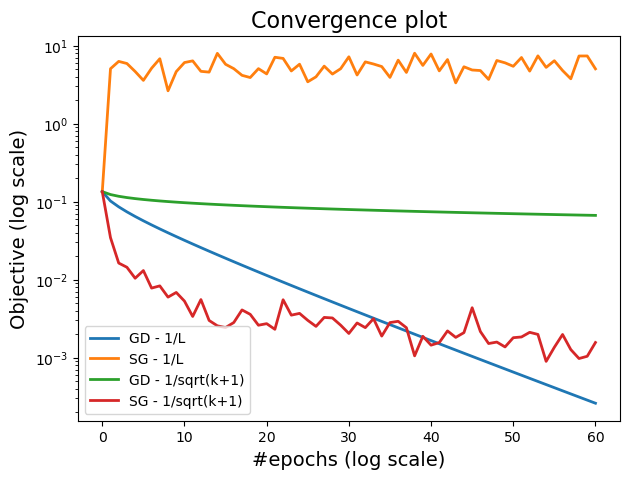

In [9]:
# Plot the comparison of variants of GD/SG with the same stepsize rule
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_log, label="GD - 1/L", lw=2)
plt.semilogy(obj_b-f_min_log, label="SG - 1/L", lw=2)
plt.semilogy(obj_c-f_min_log, label="GD - 1/sqrt(k+1)", lw=2)
plt.semilogy(obj_d-f_min_log, label="SG - 1/sqrt(k+1)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

**Question** ***How can the behavior of stochastic gradient be explained?***

**Answer**

- The stochastic gradient algorithm is not a descent method. As such, it is not guaranteed to decrease the function value in a monotone fashion (unlike gradient descent), and it may not even converge on some instances. 

- The red curve (SG with decreasing stepsize) illustrates a commonly observed behavior of SG, characterized by rapid progress during the first iterations, followed by an "oscillating phase" indicating that the method stalls and is taking small steps that marginally improve or worsen the objective value.

- The yellow curve shows a similar behavior, but the stepsize is too large for the method to obtain improvement in the function value (although theoretically, the function value decreases in expectation!). In fact, what we observe is that the method plateaus around a value that is not a minimum..

## <span style="color:rgb(92,29,79)"> 2.3 Experimenting with the step size</span>

We now run several instances of standard stochastic gradient with constant step size proportional to $\frac{1}{L}$ (using the ``step0`` parameter from the code).

In [10]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 60
n = pblinreg.n
nbset = 1
x0 = np.zeros(d)

valsstep0 = [1,0.1,0.01,0.001,0.0001]
nvals = len(valsstep0)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(x0,pblogreg,x_min_log,stepchoice=0,step0=valsstep0[val], n_iter=int(nb_epochs*n/nbset),nb=1)


Stochastic Gradient, batch size= 1 / 1000
  iter   |   fval   |  normit 
       0 | 6.93e-01 | 1.71e+00
    1000 | 5.96e+00 | 8.99e+00
    2000 | 4.89e+00 | 8.15e+00
    3000 | 5.36e+00 | 8.63e+00
    4000 | 4.93e+00 | 8.62e+00
    5000 | 6.48e+00 | 1.03e+01
    6000 | 7.05e+00 | 1.04e+01
    7000 | 7.12e+00 | 1.10e+01
    8000 | 6.46e+00 | 1.10e+01
    9000 | 6.44e+00 | 1.01e+01
   10000 | 6.70e+00 | 1.04e+01
   11000 | 6.29e+00 | 9.35e+00
   12000 | 4.17e+00 | 7.66e+00
   13000 | 5.50e+00 | 8.62e+00
   14000 | 5.31e+00 | 8.67e+00
   15000 | 5.07e+00 | 9.67e+00
   16000 | 5.83e+00 | 9.89e+00
   17000 | 5.97e+00 | 9.33e+00
   18000 | 2.89e+00 | 6.26e+00
   19000 | 5.46e+00 | 8.96e+00
   20000 | 3.54e+00 | 7.88e+00
   21000 | 6.71e+00 | 9.90e+00
   22000 | 6.80e+00 | 1.12e+01
   23000 | 7.45e+00 | 1.03e+01
   24000 | 5.30e+00 | 9.16e+00
   25000 | 5.75e+00 | 1.03e+01
   26000 | 5.10e+00 | 9.19e+00
   27000 | 4.60e+00 | 9.08e+00
   28000 | 5.53e+00 | 9.90e+00
   29000 | 6.45e+00 | 9.84e+

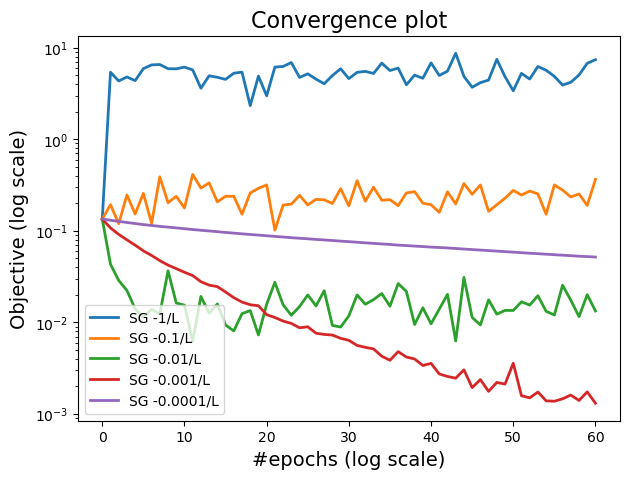

In [11]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -"+str(valsstep0[val])+"/L", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

Next, we run stochastic gradient with variants of decreasing stepsizes. Starting with a constant $\alpha_0$, we compare the sequences $\tfrac{\alpha_0}{\sqrt{k+1}}$, $\tfrac{\alpha_0}{(k+1)}$, $\tfrac{\alpha_0}{(k+1)^{1/4}}$, $\tfrac{\alpha_0}{(k+1)^{2/3}}$.

In [12]:
# Run several instances of stochastic gradient with constant batch size

nb_epochs = 60
n = pblinreg.n
nbset = 1
x0 = np.zeros(d)

decstep = [1,2/3,1/2,1/4,0]
nvals = len(decstep)

objs = np.zeros((nb_epochs+1,nvals))

for val in range(nvals):
    _, objs[:,val], _ = stoch_grad(x0,pblogreg,x_min_log,stepchoice=decstep[val],step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=1)




Stochastic Gradient, batch size= 1 / 1000
  iter   |   fval   |  normit 
       0 | 6.93e-01 | 1.71e+00
    1000 | 6.95e-01 | 1.68e+00
    2000 | 6.89e-01 | 1.66e+00
    3000 | 6.85e-01 | 1.65e+00
    4000 | 6.82e-01 | 1.64e+00
    5000 | 6.80e-01 | 1.63e+00
    6000 | 6.78e-01 | 1.63e+00
    7000 | 6.77e-01 | 1.62e+00
    8000 | 6.76e-01 | 1.62e+00
    9000 | 6.75e-01 | 1.62e+00
   10000 | 6.74e-01 | 1.61e+00
   11000 | 6.73e-01 | 1.61e+00
   12000 | 6.72e-01 | 1.61e+00
   13000 | 6.71e-01 | 1.61e+00
   14000 | 6.71e-01 | 1.60e+00
   15000 | 6.70e-01 | 1.60e+00
   16000 | 6.70e-01 | 1.60e+00
   17000 | 6.69e-01 | 1.60e+00
   18000 | 6.69e-01 | 1.60e+00
   19000 | 6.68e-01 | 1.59e+00
   20000 | 6.68e-01 | 1.59e+00
   21000 | 6.68e-01 | 1.59e+00
   22000 | 6.67e-01 | 1.59e+00
   23000 | 6.67e-01 | 1.59e+00
   24000 | 6.67e-01 | 1.59e+00
   25000 | 6.66e-01 | 1.59e+00
   26000 | 6.66e-01 | 1.59e+00
   27000 | 6.66e-01 | 1.58e+00
   28000 | 6.66e-01 | 1.58e+00
   29000 | 6.65e-01 | 1.58e+

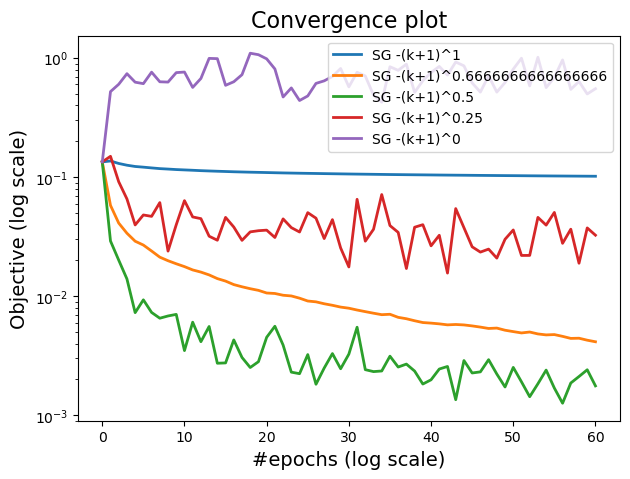

In [13]:
# Plot the comparison of variants of SG with different (constant) stepsizes
# NB: The x-axis is in epochs (1 iteration of GD).

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.set_cmap("RdPu")
for val in range(nvals):
    plt.semilogy(objs[:,val]-f_min_log, label="SG -(k+1)^"+str(decstep[val]), lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend(loc=1)

**Question** ***How do these results agree with the theoretical guarantees established during the lectures?***

**Answer**

- **For constant stepsizes:** We observe that choosing a "large" stepsize may prevent the method from converging. On the other hand, using a very small stepsize will lead to slow convergence (as illustrated by the $\tfrac{0.0001}{L}$ curve). We expect this slow convergence behavior to be followed by an oscillatory phase, which we can readily see with other stepsize choices. The red and green curves ($\tfrac{0.01}{L}$ and $\tfrac{0.001}{L}$, respectively) illustrate the trade-off between having a small stepsize, that guarantees convergence to a small neighborhood of the optimum, and having a large stepsize, that leads to faster convergence (but to a large neighborhood).

- **For decreasing stepsizes:** The observations are similar, but we expect a rapidly decreasing stepsize sequence to lead to a sublinear convergence rate, without any oscillation around a certain value. This appears to be the case for the choices $\alpha_k = \tfrac{1}{k+1}$ and $\alpha_k = \tfrac{1}{(k+1)^{2/3}}$. On the other hand, the lowest function values (in 60 epochs) are reached by using $\alpha_k = \tfrac{1}{(k+1)^{1/2}}$, despite an oscillatory trend.

## <span style="color:rgb(92,29,79)"> 2.4 Experimenting with the batch size</span>

Finally, we compare the performance of stochastic gradient with several values for the batch size (and using decreasing stepsizes) using the same epoch budget.
*Suggested values: $n_b \in \left\{1,\tfrac{n}{100},\tfrac{n}{10},\tfrac{n}{2},n \right\}$ to include stochastic gradient ($n_b=1$) and gradient descent ($n_b=n$).*

***NB: One must pay attention to the definition of the number of iterations for each variant, as it depends on the batch size.***  

In [14]:
# Test several values for the batch size using the same epoch budget.

nb_epochs = 100
n = pblogreg.n
x0 = np.zeros(d)

replace_batch=False

# Stochastic gradient (batch size 1)
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size n/100)
nbset=int(n/100)
x_b, obj_b, nits_b = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size n/10)
nbset=int(n/10)
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Batch stochastic gradient (batch size n/2)
nbset=int(n/2)
x_d, obj_d, nits_d = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)

# Gradient descent (batch size n, taken without replacement)
x_f, obj_f, nits_f = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs),nb=n)

Stochastic Gradient, batch size= 1 / 1000
  iter   |   fval   |  normit 
       0 | 2.58e+00 | 2.24e+00
    1000 | 6.58e-01 | 4.37e-01
    2000 | 6.11e-01 | 3.20e-01
    3000 | 6.11e-01 | 3.16e-01
    4000 | 5.98e-01 | 2.82e-01
    5000 | 6.05e-01 | 3.02e-01
    6000 | 5.87e-01 | 2.46e-01
    7000 | 5.76e-01 | 1.90e-01
    8000 | 5.95e-01 | 2.67e-01
    9000 | 5.85e-01 | 2.36e-01
   10000 | 5.78e-01 | 2.15e-01
   11000 | 5.86e-01 | 2.29e-01
   12000 | 5.78e-01 | 2.09e-01
   13000 | 5.78e-01 | 2.00e-01
   14000 | 5.75e-01 | 1.87e-01
   15000 | 5.77e-01 | 1.95e-01
   16000 | 5.70e-01 | 1.76e-01
   17000 | 5.76e-01 | 1.92e-01
   18000 | 5.74e-01 | 1.81e-01
   19000 | 5.73e-01 | 1.78e-01
   20000 | 5.74e-01 | 1.83e-01
   21000 | 5.75e-01 | 1.85e-01
   22000 | 5.75e-01 | 1.91e-01
   23000 | 5.74e-01 | 1.94e-01
   24000 | 5.72e-01 | 1.70e-01
   25000 | 5.68e-01 | 1.53e-01
   26000 | 5.71e-01 | 1.65e-01
   27000 | 5.67e-01 | 1.48e-01
   28000 | 5.69e-01 | 1.57e-01
   29000 | 5.69e-01 | 1.60e-

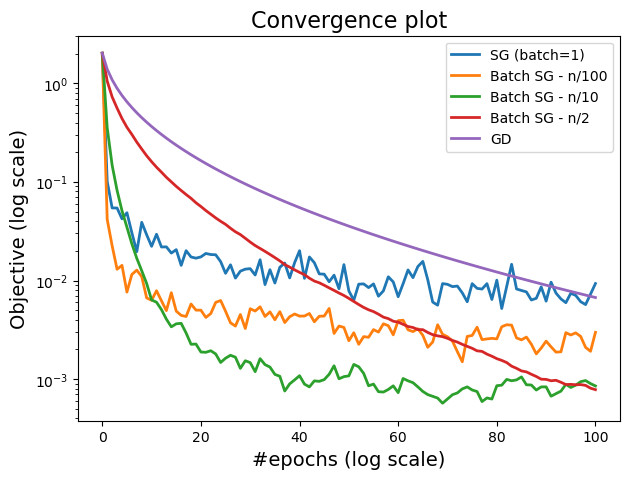

In [15]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (batch=1)", lw=2)
plt.semilogy(obj_b-f_min_lin, label="Batch SG - n/100", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG - n/10", lw=2)
plt.semilogy(obj_d-f_min_lin, label="Batch SG - n/2", lw=2)
plt.semilogy(obj_f-f_min_lin, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

Finally, we examine an observation made in theory, by comparing a batch variant with a batch size of $n_b$ with stepsize $\alpha$ to a stochastic gradient method (batch size) with step size $\tfrac{\alpha}{n_b}$.*

In [16]:
# Compare a batch method with a stochastic gradient technique using comparable step 
nb_epochs = 100
n = pblogreg.n
x0 = np.zeros(d)
replace_batch=False

# Stochastic gradient (batch size 1)
x_a, obj_a, nits_a = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=nb_epochs*n,nb=1)
# Batch stochastic gradient (batch size n/10)
nbset=int(n/10)
x_c, obj_c, nits_c = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2, n_iter=int(nb_epochs*n/nbset),nb=nbset,with_replace=replace_batch)
# Stochastic gradient (batch size 1)
x_s, obj_s, nits_s = stoch_grad(x0,pblinreg,x_min_lin,stepchoice=0.5,step0=0.2/nbset, n_iter=nb_epochs*n,nb=1)


Stochastic Gradient, batch size= 1 / 1000
  iter   |   fval   |  normit 
       0 | 2.58e+00 | 2.24e+00
    1000 | 6.81e-01 | 4.82e-01
    2000 | 6.12e-01 | 3.20e-01
    3000 | 6.10e-01 | 3.18e-01
    4000 | 6.06e-01 | 3.05e-01
    5000 | 5.91e-01 | 2.57e-01
    6000 | 5.97e-01 | 2.70e-01
    7000 | 5.85e-01 | 2.40e-01
    8000 | 5.75e-01 | 1.94e-01
    9000 | 5.74e-01 | 1.86e-01
   10000 | 5.87e-01 | 2.53e-01
   11000 | 5.81e-01 | 2.14e-01
   12000 | 5.82e-01 | 2.35e-01
   13000 | 5.78e-01 | 2.05e-01
   14000 | 5.70e-01 | 1.68e-01
   15000 | 5.84e-01 | 2.23e-01
   16000 | 5.72e-01 | 1.80e-01
   17000 | 5.70e-01 | 1.59e-01
   18000 | 5.75e-01 | 1.78e-01
   19000 | 5.81e-01 | 2.17e-01
   20000 | 5.71e-01 | 1.73e-01
   21000 | 5.79e-01 | 2.15e-01
   22000 | 5.66e-01 | 1.37e-01
   23000 | 5.73e-01 | 1.87e-01
   24000 | 5.71e-01 | 1.83e-01
   25000 | 5.72e-01 | 1.84e-01
   26000 | 5.69e-01 | 1.66e-01
   27000 | 5.66e-01 | 1.34e-01
   28000 | 5.67e-01 | 1.51e-01
   29000 | 5.67e-01 | 1.51e-

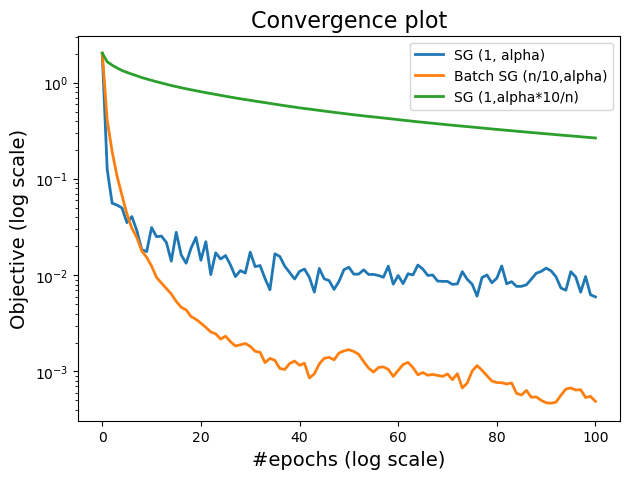

In [17]:
# Plot the comparison of variants of batch SGD with the same stepsize rule

# In terms of objective value (logarithmic scale)
plt.figure(figsize=(7, 5))
plt.semilogy(obj_a-f_min_lin, label="SG (1, alpha)", lw=2)
plt.semilogy(obj_c-f_min_lin, label="Batch SG (n/10,alpha)", lw=2)
plt.semilogy(obj_s-f_min_lin, label="SG (1,alpha*10/n)", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#epochs (log scale)", fontsize=14)
plt.ylabel("Objective (log scale)", fontsize=14)
plt.legend()

In [18]:
# This lab session is inspired from a similar lab session given by Robert Gower in 2019-2020.
# Version 4.0 - October 2023.